In [64]:
using DifferentialEquations
using Plots
using DataFrames
using Peaks

## Troubleshooting Hiscock Model

In [42]:
#Manually create repressilator to test
function oscillator(du, u, p, t)
    I = [0.1, 0, 0]
    k = 1

    du[1] = k*(phi(-u[3]) + I[1] - u[1])
    du[2] = k*(phi(-u[1]) + I[2] - u[2])
    du[3] = k*(phi(-u[2]) + I[3] - u[3])
end

tspan = [0, 100] #Span of time to integrate for
savetimes = LinRange(0, 100, 100) #linear space of points until final time
u0 = fill(0.1, N) #cannot change, can be learned
p = [] #empty for now, can change to include parameters to be varied later
prob = ODEProblem(oscillator, u0, tspan, p)
sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-6, saveat=savetimes)

┌ Warning: dt(1.4210854715202004e-14) <= dtmin(1.4210854715202004e-14) at t=0.004832143893210033, and step error estimate = 78.16594331724944. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Charlotte\.julia\packages\SciMLBase\kTUaf\src\integrator_interface.jl:599


retcode: DtLessThanMin
Interpolation: 1st order linear
t: 1-element Vector{Float64}:
 0.0
u: 1-element Vector{Vector{Float64}}:
 [0.1, 0.1, 0.1]

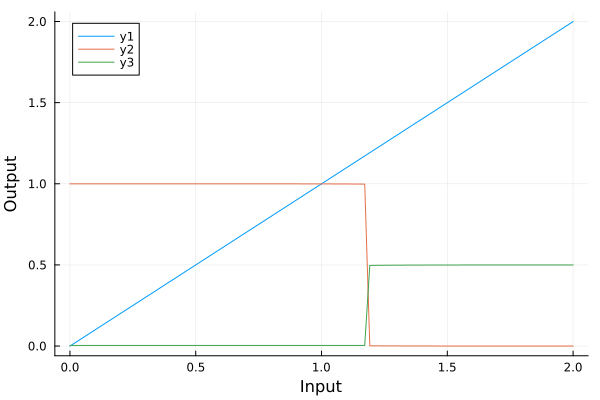

In [105]:
#Manually specify switch without matrix algebra and confirm results!
mm(x) = (1)/(1+exp(-x)) 
function switch(du, u, p, t)
    k, W, I = p
    du[1] = k*(I -u[1])
    du[2] = k*(mm(-5.5*u[1] + 12.9*u[2]) - u[2])
    du[3] = k*(mm(-5.6*u[2]) - u[3])
end

endtime = 10
resolution = 300 

tspan = [0, endtime] #Span of time to integrate for
savetimes = LinRange(0, endtime, resolution) #linear space of points until final time
u0 = [0, 0, 0] #cannot change, can be learned
 #empty for now, can change to include parameters to be varied later

sols = DataFrame()
for x in LinRange(0, 2, 100)
    p = [1, 0, x]
    prob = ODEProblem(switch, u0, tspan, p)
    sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-6, saveat=savetimes)
    sols = vcat(sols, DataFrame("u1" => [sol.u[end][1]], "u2" => [sol.u[end][2]], "u3" => [sol.u[end][3]]))
end
plot(LinRange(0, 2, 100), [sols.u1, sols.u2, sols.u3], xlabel="Input", ylabel="Output")

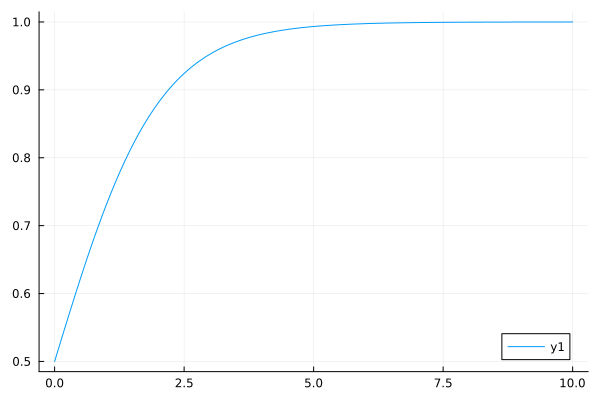

In [96]:
#Test various nonlinearities
savetimes = LinRange(0, 10, resolution)
phi(x) = 1/(exp(x) - 1)
mm(x) = (1)/(1+exp(-x))

plottimes = mm.(savetimes)
plot(savetimes, plottimes)

## Hiscock Model

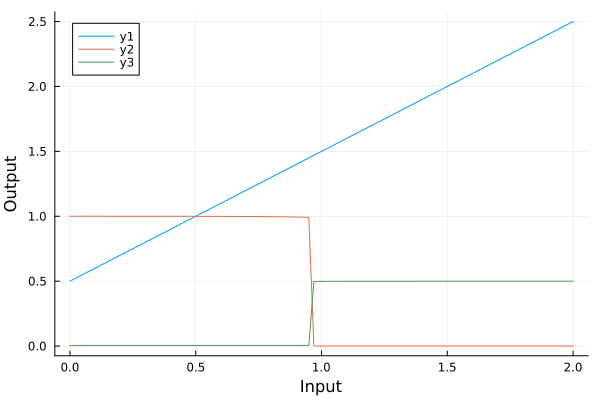

In [126]:
#Generic function to test Hiscock model
# phi(x) = 1/(exp(x) - 1) #Helper function from Hiscock - has a typo?
phi(x) = 1/(1+exp(-x))
#Given N, W, I create a ODE function and run it
function hiscock_model(N, W, k, I, u0, endtime=100, resolution=200)
    function odes(du, u, p, t)
        k, W, I = p
        for i in 1:N
            du[i] = k[i]*(phi(transpose(W[i])*u) + I[i] - u[i])
        end
    end

    tspan = [0, endtime] #Span of time to integrate for
    savetimes = LinRange(0, endtime, resolution) #linear space of points until final time
    p = [k, W, I] #empty for now, can change to include parameters to be varied later

    println(u0)
    prob = ODEProblem(odes, u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-3, abstol=1e-6, saveat=savetimes)
    return sol
end

N = 3
#I = [1, 0, 0]
W = [[0, 0, 0], [-5.5, 12.9, 0], [0, -5.6, 0]]
k = [1, 1, 1]
u0 = fill(0.1, N) #cannot change, can be learned

sols = DataFrame()
for x in LinRange(0, 2, 100)
    I = [x, 0, 0]
    sol = hiscock_model(N, W, k, I, u0, 10, 300)
    sols = vcat(sols, DataFrame("u1" => [sol.u[end][1]], "u2" => [sol.u[end][2]], "u3" => [sol.u[end][3]]))
end
plot(LinRange(0, 2, 100), [sols.u1, sols.u2, sols.u3], xlabel="Input", ylabel="Output")

## Searching for Steady States

In [155]:
#Determine number of steady states using BayesOpt method (scan initial conditions)
N = 3
I = [0, 0, 0]
W = [[3.6, -3.6, 0], [0, 3.2, -3.7], [-6.3, 0, 5.1]] #Oscillator
k = [3.3, 7.3, 1.0] # Oscillator 

W = [[0, 0, 0], [-5.5, 12.9, 0], [0, -5.6, 0]]
k = [1, 1, 1]
#Scan ICs:
ss = DataFrame()
for u in LinRange(0, 100, 10)
    u0 = fill(u, N)
    sol = hiscock_model(N, W, k, I, u0, 10, 300)
    osc_flag = false
    for i in N
        u1 =  [v[i] for v in sol.u]
        pks, vals = findmaxima(u1)
        if length(pks) > 1
            osc_flag = true
        end
    end
    if osc_flag
        ss = vcat(ss, DataFrame("u1" => [sol.u[end][1]], "u2" => [sol.u[end][2]], "u3" => [sol.u[end][3]], "oscillatory" => [1]))
    else
        ss = vcat(ss, DataFrame("u1" => [sol.u[end][1]], "u2" => [sol.u[end][2]], "u3" => [sol.u[end][3]], "oscillatory" => [0]))
    end 
end

In [ ]:
#Scan initial conditions (and input?) using BayesOpt
    #Check for oscillations using peak detection
    #If no oscillations, record steady state